# Marches Publiques - Bretagne

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import textwrap
import sys
import os
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [ ]:
from cleanup.cleanup_functions_mp import clean_mp_normalized
from cleanup.cleanup_functions_mp import cpv_to_long

# Load data

### Marches publiques

In [38]:
#\home\alessandracelani\code\alessandracelani\dataforgood\eclaireur_publique\D4G_EP_DA\data
os.path.join(os.getcwd(), 'data', 'marches_publics_normalized_data.csv')

'/home/alessandracelani/code/alessandracelani/dataforgood/eclaireur_publique/D4G_EP_DA/data/marches_publics_normalized_data.csv'

In [ ]:
mp = pd.read_csv('/data/marches_publics_normalized_data.csv', sep=";", dtype=str, encoding='utf-8')

### CPV codes

In [ ]:
cpv = pd.read_excel('/data/2025-02-25_cpv_2008_fr.xls',
                 sheet_name="CPV codes",
                 usecols="A:C",
                 skiprows=0,
                 nrows=9455
)

# Check that no empty rows were imported
cpv[cpv['CODE'].isna()].head()

# Transform the codes into a long format by level of aggregation
cpv_long = cpv_to_long(cpv)
# print(len(cpv_long))
# cpv_long.to_csv('../data/marches_publiques/cpv_long.csv', index=False)
cpv_long.head()

### SIRENE - COG (TO DO)

# Cleaned variables

**Raw variable list:** 
- **codecpv**: product code (8-digit)
  - Les deux premiers chiffres servent à identifier les divisions (XX000000-Y);
  - Les trois premiers chiffres servent à identifier les groupes (XXX00000-Y);
  - Les quatre premiers chiffres servent à identifier les classes (XXXX0000-Y);
  - Les cinq premiers chiffres servent à identifier les catégories (XXXXX000-Y);
  - **NOTE**: codes without 8 at least digits are considered as missing (< 1% of entries), but not dropped
- **DROPED - acheteur_nom**: community that is buying, missing for 83% and duplicated information in nom.
- **montant**: value of the MP
  - **NOTE**: only kept values below EUR 100 million
- **datenotification**: La date de notification du marché est celle correspondant à la réception des pièces par l'opérateur économique retenu. Pour les marchés des collectivités territoriales, de leurs groupements et de leurs établissements publics, ils prennent effet à la date de réception de la notification du marché au titulaire sous réserve du respect des dispositions du code général des collectivités territoriales relatives au contrôle de légalité.
  - **NOTE**: non standard dates were dropped
- **lieuexecution_typecode**: le lieu d'exécution specifies where the services, works, or supplies under the contract are to be provided or implemented. This could refer to a physical location (like a building, site, or office) or a geographical region, depending on the nature of the contract.
  - **TO DO**: name of the COM/DEP/REG does not match COG, names were extracted from municipal SIRENE official name. Reconcile the matching.
- **acheteur_id**: 12 digit SIRENE of the communite/department/region buying.
- **lieuexecution_code**: Where the execution of the project occurs within the deparment, region etc.
  - **TO DO**: column not analysed, pending SIRENE-COG match
- **uid**: ?
- **formeprix**: 
  - **Mixte** (Ferme et actualisable, Mixte, "Ferme, actualisable"): contracts where the pricing structure offers flexibility, either through fixed prices with possible adjustments ("Ferme et actualisable" or "Ferme, actualisable"), or through unit-based pricing (Unitaire).
  - **Révisable**: price can be adjusted or updated during the course of the contract, usually based on certain conditions or triggers. 
  - **Ferme** (Ferme, Forfaitaire, Unitaire): price or conditions of the contract are fixed and will not change over the course of the agreement. Forfaitaire and Unitaire offer simpler fixed or unit-based pricing respectively.
  - **NA** (none): information not available
- **datepublicationdonnees**: data when the information was published (online? )
  - **NOTE**: 17% of entries have ta publication date that comes before the execution date. 
  - **TO DO**: decide if we need to drop the inconsitent dates. I suggest dropping where inconsisentence is > 30 days (for discussion)
- **lieuexecution_nom**: location where the MP occured
  - **TO DO**: analyse this column, map where the execution happens within a REG/DEP
- **objet**: description of the MP request.
- **nature**: type of agreement regrouped into:
  - Marche ('MARCHE', 'Marché')
  - Accord-cadre ('ACCORD-CADRE', 'Accord-cadre'): Framework agreements set the terms for future contracts but do not themselves commit to specific purchases.
  - Marché subséquent ('MARCHE SUBSEQUENT', 'Marché subséquent'): contracts that follow a framework agreement.
  - Marché de partenariat ('MARCHE DE PARTENARIAT', Marché de partenariat): long-term partnerships, often for large infrastructure projects.
  - 'Marché hors accord cadre'
  - NA (nan)
- **dureemois**: duration of contract in months 
  -  only kept duration below 25 years
- **procedure**: type of procedure
  - Procédure adaptée                                         
  - Appel d'offres ouvert                                                  
  - Marché public négocié sans publicité ni mise en concurrence préalable   
  - Procédure négociée avec mise en concurrence préalable                  
  - Procédure concurrentielle avec négociation                               
  - Appel d'offres restreint                                               
  - Marché passé sans publicité ni mise en concurrence préalable           
  - Procédure avec négociation                                            
  - Dialogue compétitif 
  - NA (nan)
- **id**: ??? ID of transation? There are duplicated entries
- **_type**: ??? Marché is coded for some values.
- **siren**: 8 digit SIREN code of the buying COM/DEP/REG
- **nom**: name of the buying COM/DEP/REG
- **type**: type of buyer (COM, DEP CC, CA, MET, REG, CU, CTU, EPT)
- **titulaires**: seller name. Each item is a list, as the MP may involve more than one seller.
  - **TO DO**: this can be matched to the SIRENE number using the name. 


In [5]:
mp_clean = clean_mp_normalized(mp, cpv_long, missing_string='Unknown')

Cleaning montant: 467119 entries
     After dropping negatives: 467104
     After dropping below 1000€: 467104
     After dropping above 100 million: 466052
Cleaning dates: 466052
    After removing non valid dates from notification: 465985
Cleaning datenotification: 465985
    After removing non valid dates from publication: 465936
    After dropping rows before 2016: 463834
Cleaning duration of contract in months: 463834
    After dropping durations over 25 years: 463524
    After dropping zeros: 463362
Cleaning procedure: 463362
    After dropping NaNs: 462329
Share of dropped observations: 0.010254346322885577


# Discussion on data cleaning

### Publication vs. notification date
Publication date comes before notification date for 17% of entries.
How should we deal with this?

In [363]:
mp_clean.nlargest(5, 'publication_delay').head()
mp_clean[mp_clean['publication_delay'] < 0].head()
mp_clean['publication_delay_segment'] = pd.cut(
    mp_clean['publication_delay'],
    bins=[-float('inf'), -30, 0, 7, 365, float('inf')],
    labels=['Below -30', '-30 to 0', '0 to 7', '7 to 365', 'More than 365']
)

mp_clean['publication_delay_segment'].value_counts() / len(mp_clean)

7 to 365         0.594559
0 to 7           0.189093
-30 to 0         0.122835
Below -30        0.048745
More than 365    0.044769
Name: publication_delay_segment, dtype: float64

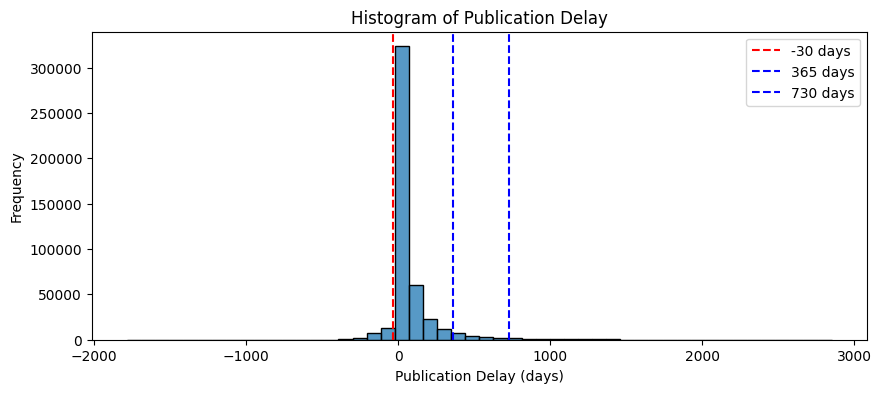

In [379]:
# Plot the histogram
plt.figure(figsize=(10, 4))
sns.histplot(mp_clean['publication_delay'], bins=50, kde=False)
plt.axvline(x=-30, color='red', linestyle='dashed', linewidth=1.5, label='-30 days')
plt.axvline(x=365, color='blue', linestyle='dashed', linewidth=1.5, label='365 days')
plt.axvline(x=730, color='green', linestyle='dashed', linewidth=1.5, label='730 days')

# Add labels and title
plt.xlabel("Publication Delay (days)")
plt.ylabel("Frequency")
plt.title("Histogram of Publication Delay")
plt.legend()

# Show the plot
plt.show()

### Montant: very high values are likely mistakes based on data distribution

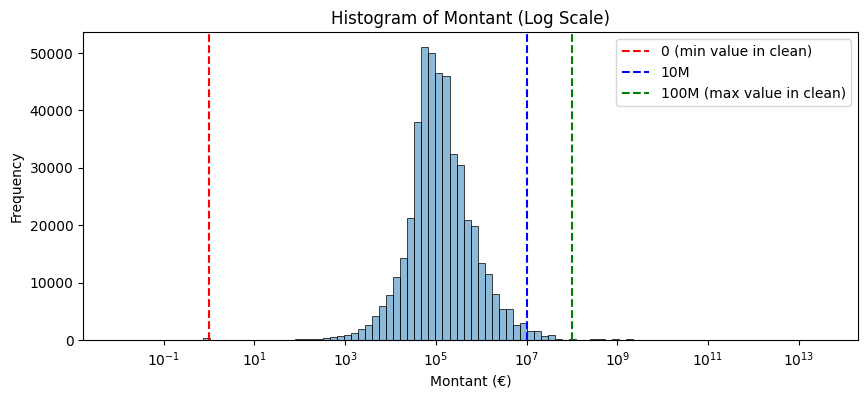

In [388]:
# Plot histogram with log scale
plt.figure(figsize=(10, 4))
sns.histplot(mp['montant'].astype(float), bins=100, log_scale=True, kde=True)

# Add vertical lines
plt.axvline(x=1, color='red', linestyle='dashed', linewidth=1.5, label='0 (min value in clean)')
plt.axvline(x=10_000_000, color='blue', linestyle='dashed', linewidth=1.5, label='10M')
plt.axvline(x=100_000_000, color='green', linestyle='dashed', linewidth=1.5, label='100M (max value in clean)')

# Labels, title, and legend
plt.xlabel("Montant (€)")
plt.ylabel("Frequency")
plt.title("Histogram of Montant (Log Scale)")
plt.legend()

# Show plot
plt.show()

### Duration: durations of over 300 months (25 years) were dropped

Share of entries in raw data with over 25 years of duration: 0.0006700648014745707


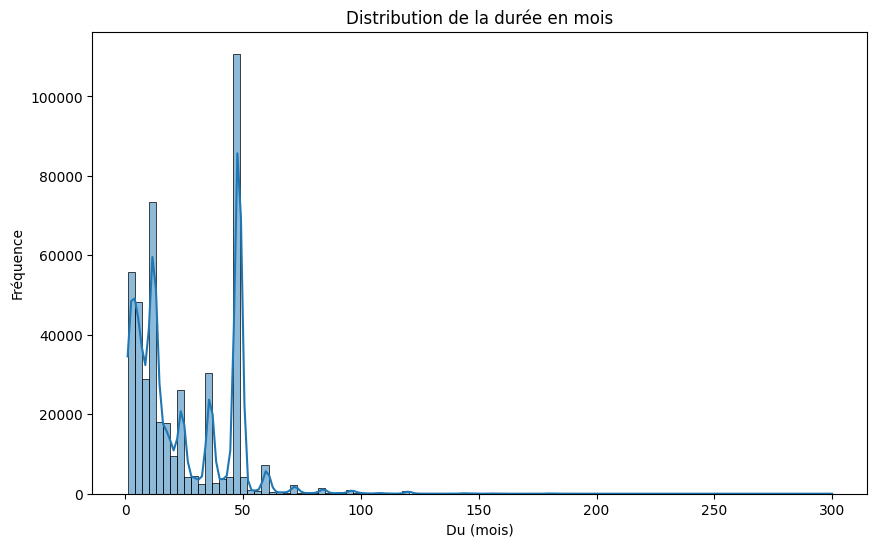

In [396]:
print(f"Share of entries in raw data with over 25 years of duration: {len(mp[mp['dureemois'].astype(float) > 300]['dureemois'].astype(float)) / len(mp)}")

plt.figure(figsize=(10, 6))
sns.histplot(mp_clean['duration_months_numeric'], bins=100, kde=True)
plt.xlabel("Du (mois)")
plt.ylabel("Fréquence")
plt.title("Distribution de la durée en mois")
plt.show()

### Missing values

In [23]:
mp.isna().sum() / len(mp)

Unnamed: 0                0.000000
codecpv                   0.003560
acheteur_nom              0.836183
montant                   0.000000
datenotification          0.000000
lieuexecution_typecode    0.000002
acheteur_id               0.000000
lieuexecution_code        0.000004
uid                       0.251662
formeprix                 0.000000
datepublicationdonnees    0.004119
lieuexecution_nom         0.001593
objet                     0.000000
nature                    0.000034
dureemois                 0.000000
procedure                 0.002209
id                        0.008332
_type                     0.653388
siren                     0.000000
nom                       0.000000
type                      0.000000
titulaires                0.001700
dtype: float64

# PReliminary variable analysis

Unit of analysis: Bretagne (233500016, 8-digit)


In [447]:
filter = "233500016"
# Grande Est: 200052264; Bretagne: "233500016"
mp_filtered = mp_clean[mp_clean['siren'] == str(filter)].copy()
print(f"Filtering for {mp_filtered['nom'].iloc[0]}")

Filtering for Bretagne


### Is my region publishing mandatory or voluntarily? (this could be bad data too -> ask the association)

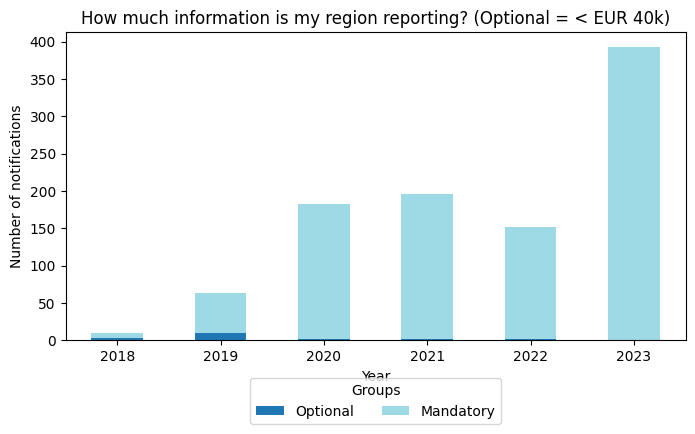

In [448]:
df_graph = mp_filtered.pivot_table(index='notification_year', columns='publication_requirement', values='buyer_sirene', aggfunc='count', fill_value=0)
df_graph.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,4))

# Set the labels and title
plt.title('How much information is my region reporting? (Optional = < EUR 40k)')
plt.xlabel('Year')
plt.ylabel('Number of notifications')
plt.xticks(rotation=0)
plt.legend(title='Groups', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

### Which types of products and services are most frequently procured in each region? How has public spending on procurement evolved over the years in each region?

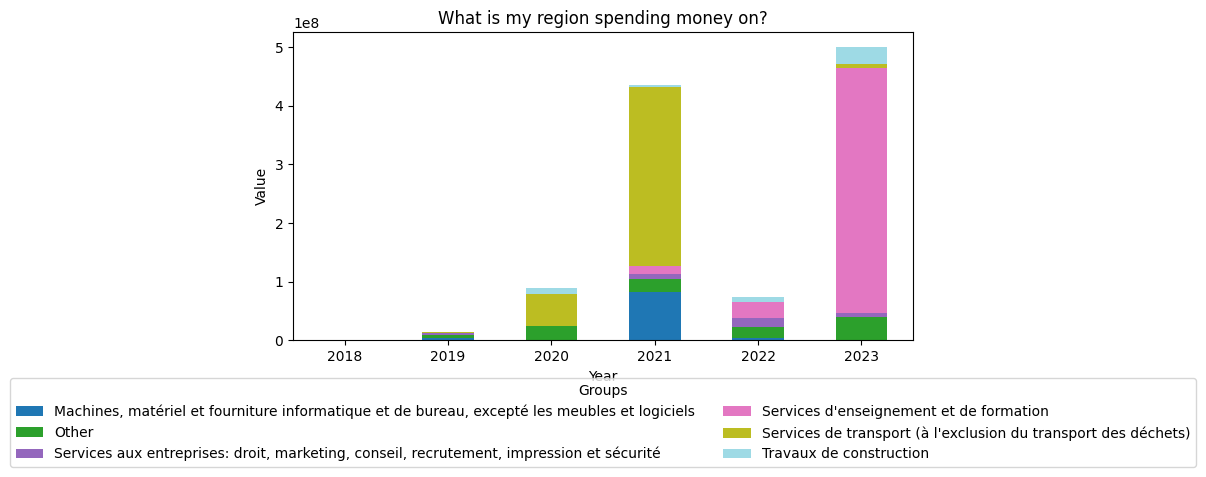

In [449]:
# Plot the stacked bar chart using Seaborn
number_of_groups = 5

# Find the tota value by group
df_graph = mp_filtered.copy()
df_groups = mp_filtered.groupby('cpv_2_label')['value_numeric'].sum().sort_values(ascending=False)
top_groups = df_groups.head(number_of_groups).index

# Step 3: Replace the groups not in the top 5 with 'Other'
df_graph['temp'] = df_graph['cpv_2_label'].apply(lambda x: x if x in top_groups else 'Other')

# Re-group the data
df_graph = df_graph.pivot_table(index='notification_year', columns='temp', values='value_numeric', aggfunc='sum', fill_value=0)
df_graph.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,4))

# Set the labels and title
plt.title('What is my region spending money on?')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(title='Groups', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)


# Show the plot
plt.show()

### Type of public procurement: fixed, mixed or adjustable

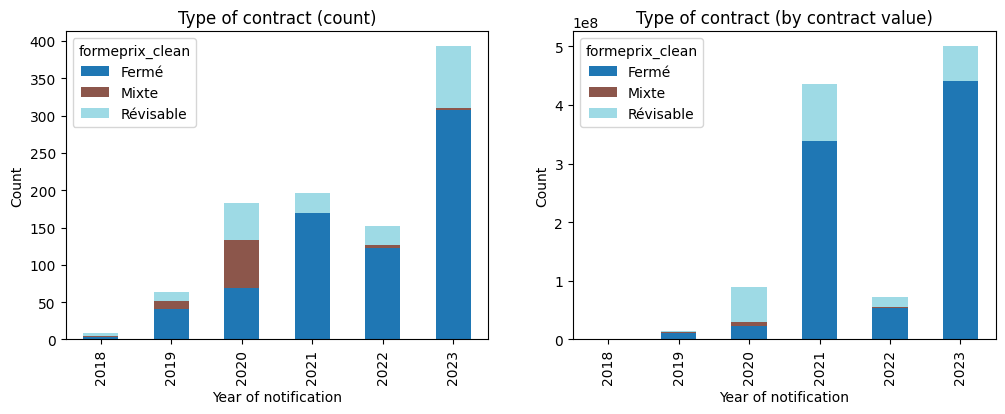

In [450]:
# Create a figure and axes with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1st plot: number of contracts
df_graph = mp_filtered.pivot_table(index='notification_year', columns='formeprix_clean', values='buyer_sirene', aggfunc='count', fill_value=0)
df_graph.plot(kind='bar', stacked=True, colormap='tab20', ax=axes[0])
axes[0].set_title('Type of contract (count)')
axes[0].set_xlabel('Year of notification')
axes[0].set_ylabel('Count')


# 2nd plot: value of contracts
df_graph2 = mp_filtered.pivot_table(index='notification_year', columns='formeprix_clean', values='value_numeric', aggfunc='sum', fill_value=0)
df_graph2.plot(kind='bar', stacked=True, colormap='tab20', ax=axes[1])
axes[1].set_title('Type of contract (by contract value)')
axes[1].set_xlabel('Year of notification')
axes[1].set_ylabel('Count')

# Show the plot
plt.show()

### Are there delays between contract awards and public disclosure of procurement information?

In [451]:
mp_filtered.groupby('notification_year')['publication_delay'].apply(lambda x: (x < 0).mean())

notification_year
2018    0.000000
2019    0.269841
2020    0.043716
2021    0.806122
2022    0.230263
2023    0.694656
Name: publication_delay, dtype: float64

<Figure size 1000x600 with 0 Axes>

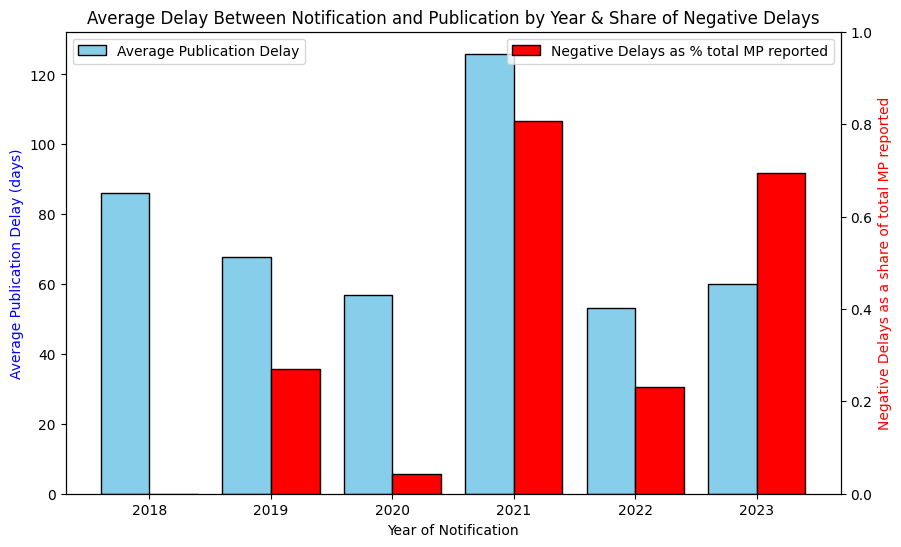

: 

In [ ]:
# Compute the average delay per year
avg_delay_per_year = mp_filtered[mp_filtered['publication_delay'] > 0].groupby('notification_year')['publication_delay'].mean()

# Compute the share of negative delays by year
negative_delay_share = mp_filtered.groupby('notification_year')['publication_delay'].apply(lambda x: (x < 0).mean())

# Create the bar plot for average delay
plt.figure(figsize=(10, 6))

# Set up the positions for the bars
x = np.arange(len(avg_delay_per_year))  # X positions for the bars

# Plot the average delay bar plot
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(x - 0.2, avg_delay_per_year, width=0.4, color='skyblue', edgecolor='black', label="Average Publication Delay")

# Plot the negative delay share bar plot next to the first
ax2 = ax1.twinx()
ax2.bar(x + 0.2, negative_delay_share, width=0.4, color='red', edgecolor='black', label="Negative Delays as % total MP reported")

# Add labels and title
ax1.set_xlabel("Year of Notification")
ax1.set_ylabel("Average Publication Delay (days)", color='blue')
ax2.set_ylabel("Negative Delays as a share of total MP reported", color='red')

# Set the y-axis limit for the second plot (share of negative delays)
ax2.set_ylim(0, 1)

# Adjust the x-axis to show the year labels properly
ax1.set_xticks(x)
ax1.set_xticklabels(avg_delay_per_year.index)

# Add title and legend
plt.title("Average Delay Between Notification and Publication by Year & Share of Negative Delays")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()

### Which market procedures are most commonly used in public procurement?

### What share of public procurement is awarded through open competition versus negotiated procedures?

### Which companies receive the most public contracts in each region?

### Are certain companies repeatedly winning contracts without open bidding?

### How often do public contracts go to companies based outside the region where the project takes place?
More data needed: need to get SIRENE of companies based on name and then assign them their location and cross check with the buyer's.

### How often do public contracts go to companies based outside the region where the project takes place?
Need to identify SIRENE of companies based on name and then cross-match their location/size
### Are public contracts concentrated among a small number of suppliers, or is there diversity in suppliers?
Need to identify SIRENE of companies based on name and then cross-match their location/size